In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from sklearn import metrics,preprocessing,svm

from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

In [2]:
PATH_TO_DATA = '../data/raw/data.csv'

In [3]:
SEED = np.random.randint(low=0,high=1000,size=1)[0]
SEED

575

In [4]:
df = pd.read_csv(PATH_TO_DATA)

In [5]:
df.head()

,V1,V2,V3,V4,Grupo
0,5.1,3.5,1.4,0.2,G1
1,4.9,3.0,1.4,0.2,G1
2,4.7,3.2,1.3,0.2,G1
3,4.6,3.1,1.5,0.2,G1
4,5.0,3.6,1.4,0.2,G1


In [6]:
X = df[["V1","V2","V3","V4"]].values
y = df[["Grupo"]].values

In [7]:
X.dtype,y.dtype

(dtype('float64'), dtype('O'))

In [8]:
k_fold = KFold(n_splits=10, random_state=SEED,shuffle=True)

accuracies = []

y_preds = []
y_tests = []

for train_idx, test_idx in k_fold.split(X):
       
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx].ravel()
    y_test = y[test_idx].ravel()
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train_scaled,y_train)
    
    y_pred = clf.predict(X_test_scaled)
    
    accuracy = metrics.accuracy_score(y_test,y_pred)
    
    accuracies.append(accuracy)
    
    # vou usar para montar a matriz de confusão
    y_preds.append(y_pred)
    y_tests.append(y_test)
    
accuracies = np.array(accuracies)

print(accuracies.mean())    

0.966666666667


Comentários:

- KFold é um mecanismo para fazer validação cruzada (cross validation) para o treinamento do nosso modelo. Isso é uma forma de evitar overfitting (falhar em generalizar o modelo para casos fora do conjunto de treinamento) e, ao mesmo tempo, nos deixar usar todos os dados do dataset para treinamento.

- Eu usei shuffle=True pois o dataset veio ordenado e, se não for embaralhado, os splits vão ser quase todos dentro da mesma classe.

- Eu usei random_state=SEED para termos reproducibilidade.

- Os dados foram normalizados dentro do split para não haver vazamento de informação. Esse tipo de normalização foi usada pois o nosso dataset não tem muitos outliers.

- Os parâmetros default do classificador SVM foram usados (kernel=RBF).

- Foi usada Acurácia como métrica de sucesso pois o nosso dataset está bem balanceado com relação às classes (há o mesmo número de amostras em cada classe).

# Matriz de confusão

Uma matriz de confusão é usada para analisar as ocorrências de falsos positivos e de falsos negativos no resultado do modelo.

In [9]:
y_tests = np.array(y_tests).ravel()
y_preds = np.array(y_preds).ravel()

cnf_matrix = metrics.confusion_matrix(y_tests, y_preds)

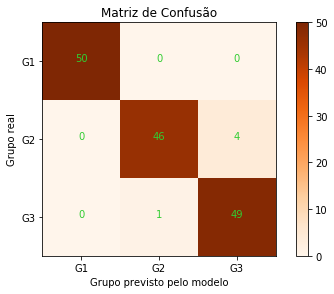

In [10]:
colour_map = plt.cm.Oranges

plt.imshow(cnf_matrix, interpolation='nearest', cmap=colour_map)
plt.title('Matriz de Confusão')
plt.colorbar()

# plotar o gráfico com a matriz derivada no passo anterior
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'),
             horizontalalignment="center", color="limegreen")
    
tick_marks = np.array([0,1,2])
plt.xticks(tick_marks, ["G1","G2","G3"])
plt.yticks(tick_marks, ["G1","G2","G3"])    
    
plt.tight_layout()
plt.ylabel('Grupo real')
plt.xlabel('Grupo previsto pelo modelo')

Comentários:

- A matriz de confusão mostra que os poucos casos de erro do modelo de dividem em dois casos:

 - 2 casos erradamente classificados como G2 quando o grupo real era G3
 - 5 casos erradamente classificados como G3 quando o grupo real era G2
 
- Essa informação é valiosa pois nos mostra exatamente em que casos o modelo tem uma taxa alta de acerto e em que casos há alguns erros.

- Como estamos usando validação cruzada (cross-validation), o número de acertos/erros em cada um dos 10 "folds" foi somado para se obter o resultado final.